[House Price](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


* 회귀(Regrassion) 란?
둘 사이의 상관관계를 모델링하는 기법( Y = w₁X₁ + w₂X₂ + ... )
w(weight) = 회귀계수(Coefficient) 또는 가중치(Weight)
Fiture와 결정값 학습을 통해 최적의 회귀계수를 찾는 것.

*독립변수 개수
  # 1개 : 단일회귀
  # 多  : 다중회귀
*회귀계수 결합
  # 선형회귀 (가장 많이 사용. 규제 방법에 따라 유형 나뉨)
  # 비선형회귀

* 분석절차
1. EDA
  - dataframe 타입별(카테고리형/수치형) 피쳐 분류

2. 결측치 확인/피쳐삭제/채우기
  - 결측값 대체(수치형:평균 / Object형:'None')

3. 수치형 피쳐 데이터값 확인
  - target 피쳐 분리
  - unique ID 피쳐 삭제

4. 수치형 피쳐 상관분석
  - target(SalePrice)에 영향을 주는 상위 n개 피쳐에 대해서만 상관 분석
  - target(SalePrice)에 영향을 주는 상위 n개 피쳐에 대해서만 데이터 분포도(산점도) 확인

5. 수치형 피쳐 인코딩
  - 인코딩(수치형:unique[:13]

6. 수치형 정규화
  - 타켓 분포도 확인/정규화
  - 정규화/스케일 (수치형:skew[:25] 로그변환

7. Object형 시각화

8. Outlier 처리
  -아웃라이어제거(수치형:IQR) 

9. Object형 피쳐 인코딩

10. 학습모델 선정 / 평가

11. 검증 / 튜닝

## Library & API

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from scipy.stats import skew #왜도
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings(action="ignore")

%matplotlib inline

분석 데이터 로드

In [59]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/train.csv")
df_t = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/test.csv")
df_s = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/price_submission.csv")
print(df.shape)
print(df_t.shape)
print(df_s.shape)

(1460, 81)
(1459, 80)
(1459, 2)


### 1. dataframe 타입별(카테고리형/수치형) 피쳐 분류

In [60]:
def type_check(df):
    object_feature = df.dtypes[df.dtypes == 'object'].index
    #object_feature = df.select_dtypes(include = ["object"]).columns
    numeric_feature = df.dtypes[df.dtypes != 'object'].index
    # numeric_column = df.columns - object_column
    print(df.dtypes.value_counts())
    print("object type:",object_feature)  #숫치형->범주화/인코딩
    print("numeric type:",numeric_feature) #스케일,범주화
    return object_feature, numeric_feature

object_feature, numeric_feature = type_check(df)

def type_check(df_t):
    object_feature = df_t.dtypes[df_t.dtypes == 'object'].index
    #object_feature = df_t.select_dtypes(include = ["object"]).columns
    numeric_feature = df_t.dtypes[df_t.dtypes != 'object'].index
    # numeric_column = df.columns - object_column
    print(df_t.dtypes.value_counts())
    print("object type:",object_feature)  #숫치형->범주화/인코딩
    print("numeric type:",numeric_feature) #스케일,범주화
    return object_feature, numeric_feature

object_feature, numeric_feature = type_check(df_t)

object     43
int64      35
float64     3
dtype: int64
object type: Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')
numeric type: Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea

### 2. 결측치 확인/피쳐삭제/채우기
- 대량의 피쳐 분석의 경우 : 결측치 피쳐 삭제부터

In [61]:
# ---------- dataframe 결측치 확인/제거
def null_feature_check(df, drop_cnt=None):
    isnull_feature = df.isnull().sum()[df.isnull().sum()>0].index
    null_df = pd.DataFrame()
    null_df["null_cnt"]  = df[isnull_feature].isnull().sum()
    null_df["null_rate"]  = df[isnull_feature].isnull().sum() / df.shape[0] * 100
    print(null_df)

    # FireplaceQu     690 47.260274  --- 모델 평가 후 재검토 필요
    if drop_cnt != None :
        drop_isnull_feature = df.isnull().sum()[df.isnull().sum() > drop_cnt].index
        #['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']
        print("\ndrop_feature:",drop_isnull_feature)

        # df.drop(drop_isnull_feature, axis=1, inplace=True)
        df = df.drop(drop_isnull_feature, axis=1)
        print(df.shape)  #(1460, 76)
    return df

df = null_feature_check(df, 600)

              null_cnt  null_rate
LotFrontage        259  17.739726
Alley             1369  93.767123
MasVnrType           8   0.547945
MasVnrArea           8   0.547945
BsmtQual            37   2.534247
BsmtCond            37   2.534247
BsmtExposure        38   2.602740
BsmtFinType1        37   2.534247
BsmtFinType2        38   2.602740
Electrical           1   0.068493
FireplaceQu        690  47.260274
GarageType          81   5.547945
GarageYrBlt         81   5.547945
GarageFinish        81   5.547945
GarageQual          81   5.547945
GarageCond          81   5.547945
PoolQC            1453  99.520548
Fence             1179  80.753425
MiscFeature       1406  96.301370

drop_feature: Index(['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], dtype='object')
(1460, 76)


In [62]:
# ---------- test 결측치 확인/제거
def null_feature_check(df_t, drop_cnt=None):
    isnull_feature = df_t.isnull().sum()[df_t.isnull().sum()>0].index
    null_df_t = pd.DataFrame()
    null_df_t["null_cnt"]  = df_t[isnull_feature].isnull().sum()
    null_df_t["null_rate"]  = df_t[isnull_feature].isnull().sum() / df_t.shape[0] * 100
    print(null_df_t)

    # FireplaceQu     690 47.260274  --- 모델 평가 후 재검토 필요
    if drop_cnt != None :
        drop_isnull_feature = df_t.isnull().sum()[df_t.isnull().sum() > drop_cnt].index
        #['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']
        print("\ndrop_feature:",drop_isnull_feature)

        # df.drop(drop_isnull_feature, axis=1, inplace=True)
        df_t = df_t.drop(drop_isnull_feature, axis=1)
        print(df_t.shape)  #(1460, 76)
    return df_t

df_t = null_feature_check(df_t)
df_t = null_feature_check(df_t, 600)

              null_cnt  null_rate
MSZoning             4   0.274160
LotFrontage        227  15.558602
Alley             1352  92.666210
Utilities            2   0.137080
Exterior1st          1   0.068540
Exterior2nd          1   0.068540
MasVnrType          16   1.096642
MasVnrArea          15   1.028101
BsmtQual            44   3.015764
BsmtCond            45   3.084304
BsmtExposure        44   3.015764
BsmtFinType1        42   2.878684
BsmtFinSF1           1   0.068540
BsmtFinType2        42   2.878684
BsmtFinSF2           1   0.068540
BsmtUnfSF            1   0.068540
TotalBsmtSF          1   0.068540
BsmtFullBath         2   0.137080
BsmtHalfBath         2   0.137080
KitchenQual          1   0.068540
Functional           2   0.137080
FireplaceQu        730  50.034270
GarageType          76   5.209047
GarageYrBlt         78   5.346127
GarageFinish        78   5.346127
GarageCars           1   0.068540
GarageArea           1   0.068540
GarageQual          78   5.346127
GarageCond    

In [63]:
# ---------- dataframe 결측치 채우기 / 최종확인
# objct_type_fillna(df, object_feature)
# numeric_type_fillna(df, numeric_feature)
df.fillna(df.mean(), inplace=True)
df.replace(np.nan, 'None', inplace=True)
df = null_feature_check(df)


# ---------- test 결측치 채우기 / 최종확인
df_t.fillna(df_t.mean(), inplace=True)
df_t.replace(np.nan, 'None', inplace=True)
df_t = null_feature_check(df_t)

Empty DataFrame
Columns: [null_cnt, null_rate]
Index: []
Empty DataFrame
Columns: [null_cnt, null_rate]
Index: []


In [64]:
df[['BsmtFinSF2', 'BsmtFinSF1']].isnull().sum()

BsmtFinSF2    0
BsmtFinSF1    0
dtype: int64

In [65]:
df_t[['BsmtFinSF2', 'BsmtFinSF1']].isnull().sum()

BsmtFinSF2    0
BsmtFinSF1    0
dtype: int64

### 3. 수치형 피쳐 데이터값 확인

In [66]:
df[numeric_feature].head(10).T

,0,1,2,3,4,5,6,7,8,9
Id,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.000000,9.0,10.0
MSSubClass,60.0,20.0,60.0,70.0,60.0,50.0,20.0,60.000000,50.0,190.0
LotFrontage,65.0,80.0,68.0,60.0,84.0,85.0,75.0,70.049958,51.0,50.0
LotArea,8450.0,9600.0,11250.0,9550.0,14260.0,14115.0,10084.0,10382.000000,6120.0,7420.0
OverallQual,7.0,6.0,7.0,7.0,8.0,5.0,8.0,7.000000,7.0,5.0
OverallCond,5.0,8.0,5.0,5.0,5.0,5.0,5.0,6.000000,5.0,6.0
YearBuilt,2003.0,1976.0,2001.0,1915.0,2000.0,1993.0,2004.0,1973.000000,1931.0,1939.0
YearRemodAdd,2003.0,1976.0,2002.0,1970.0,2000.0,1995.0,2005.0,1973.000000,1950.0,1950.0
MasVnrArea,196.0,0.0,162.0,0.0,350.0,0.0,186.0,240.000000,0.0,0.0
BsmtFinSF1,706.0,978.0,486.0,216.0,655.0,732.0,1369.0,859.000000,0.0,851.0


In [67]:
df_t[numeric_feature].head(10).T

,0,1,2,3,4,5,6,7,8,9
Id,1461.0,1462.0,1463.0,1464.0,1465.0,1466.0,1467.000000,1468.0,1469.0,1470.0
MSSubClass,20.0,20.0,60.0,60.0,120.0,60.0,20.000000,60.0,20.0,20.0
LotFrontage,80.0,81.0,74.0,78.0,43.0,75.0,68.580357,63.0,85.0,70.0
LotArea,11622.0,14267.0,13830.0,9978.0,5005.0,10000.0,7980.000000,8402.0,10176.0,8400.0
OverallQual,5.0,6.0,5.0,6.0,8.0,6.0,6.000000,6.0,7.0,4.0
OverallCond,6.0,6.0,5.0,6.0,5.0,5.0,7.000000,5.0,5.0,5.0
YearBuilt,1961.0,1958.0,1997.0,1998.0,1992.0,1993.0,1992.000000,1998.0,1990.0,1970.0
YearRemodAdd,1961.0,1958.0,1998.0,1998.0,1992.0,1994.0,2007.000000,1998.0,1990.0,1970.0
MasVnrArea,0.0,108.0,0.0,20.0,0.0,0.0,0.000000,0.0,0.0,0.0
BsmtFinSF1,468.0,923.0,791.0,602.0,263.0,0.0,935.000000,0.0,637.0,804.0


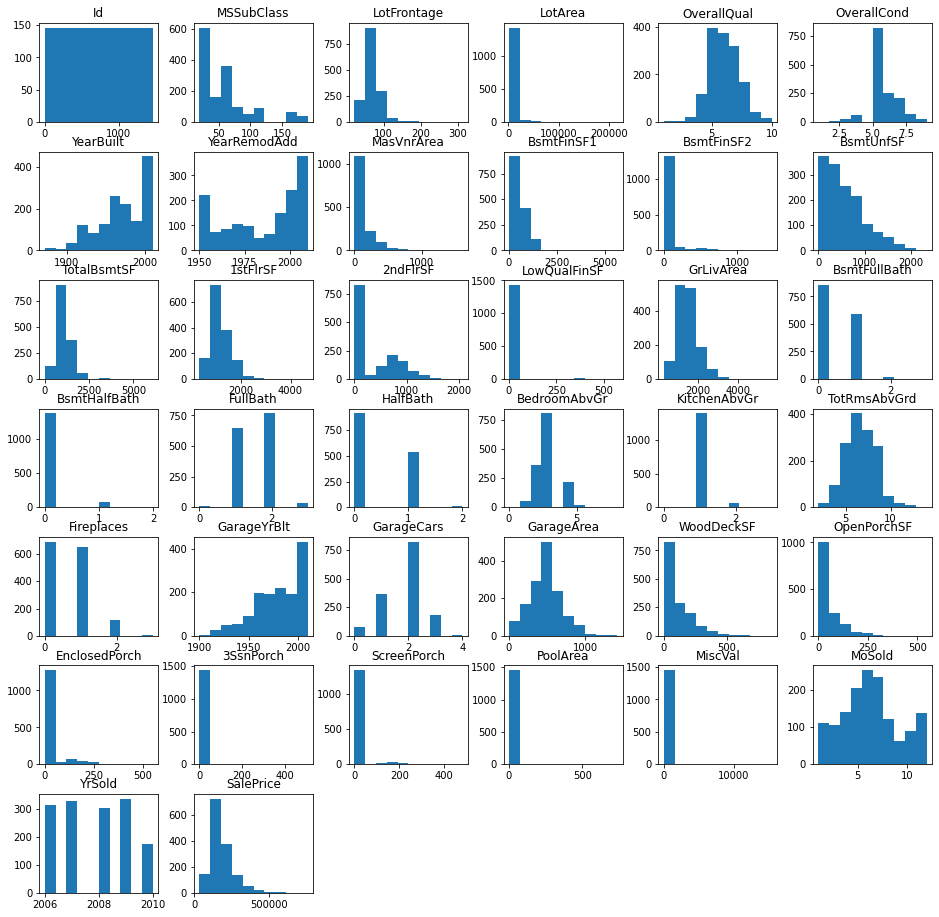

In [68]:
df.hist(bins=10, figsize=(16,16), grid=False);
plt.show()

unique ID 피쳐 삭제

In [69]:
df.drop('Id', axis=1, inplace=True)


numeric_feature = df.dtypes[df.dtypes != 'object'].index  #pandas.core.indexes.base.Index
print(numeric_feature)

#-------------------------------

df_t.drop('Id', axis=1, inplace=True)


numeric_feature_t = df_t.dtypes[df_t.dtypes != 'object'].index  #pandas.core.indexes.base.Index
print(numeric_feature_t)

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')
Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars

### 4. 수치형 피쳐 상관분석

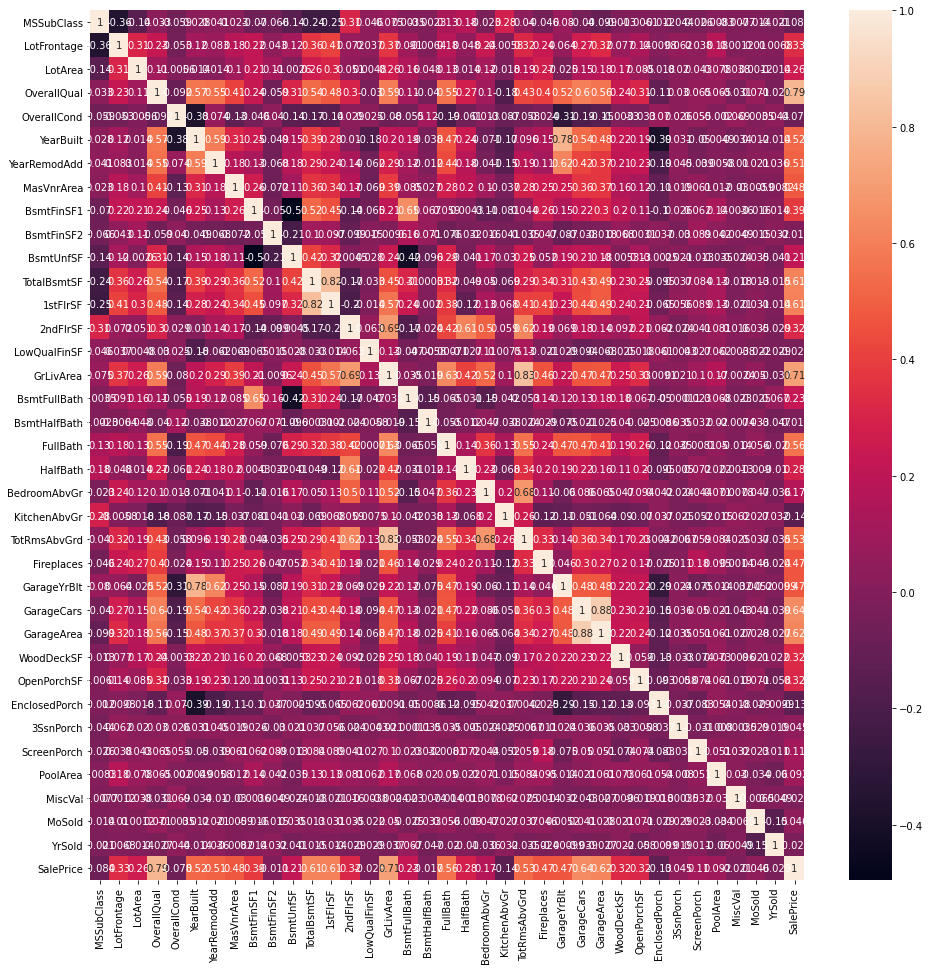

In [14]:
## 수치형 피쳐 상관분석
plt.figure(figsize=(16,16))
sns.heatmap(df[numeric_feature].corr(), annot=True)
plt.show()

target(SalePrice)에 영향을 주는 상위 n개 피쳐에 대해서만 상관 분석

In [70]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [71]:
df.shape

(1460, 75)

In [72]:
df_t.shape

(1459, 74)

In [73]:
vif_data = df[numeric_feature].iloc[:,:-1]
vif_data.info()

vif_data_t = df_t[numeric_feature_t].iloc[:,:]
vif_data_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 36 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   LotFrontage    1460 non-null   float64
 2   LotArea        1460 non-null   int64  
 3   OverallQual    1460 non-null   int64  
 4   OverallCond    1460 non-null   int64  
 5   YearBuilt      1460 non-null   int64  
 6   YearRemodAdd   1460 non-null   int64  
 7   MasVnrArea     1460 non-null   float64
 8   BsmtFinSF1     1460 non-null   int64  
 9   BsmtFinSF2     1460 non-null   int64  
 10  BsmtUnfSF      1460 non-null   int64  
 11  TotalBsmtSF    1460 non-null   int64  
 12  1stFlrSF       1460 non-null   int64  
 13  2ndFlrSF       1460 non-null   int64  
 14  LowQualFinSF   1460 non-null   int64  
 15  GrLivArea      1460 non-null   int64  
 16  BsmtFullBath   1460 non-null   int64  
 17  BsmtHalfBath   1460 non-null   int64  
 18  FullBath

In [74]:
vif = pd.DataFrame()
vif['Features'] = vif_data.columns
vif['vif'] = [variance_inflation_factor(
             vif_data.values, i) for i in range(vif_data.shape[1])]
vif.sort_values(by='vif',ascending=False)

,Features,vif
9,BsmtFinSF2,inf
8,BsmtFinSF1,inf
15,GrLivArea,inf
14,LowQualFinSF,inf
13,2ndFlrSF,inf
12,1stFlrSF,inf
11,TotalBsmtSF,inf
10,BsmtUnfSF,inf
35,YrSold,2.411126e+04
24,GarageYrBlt,2.290578e+04


In [75]:
vif_t = pd.DataFrame()
vif_t['Features'] = vif_data_t.columns
vif_t['vif_t'] = [variance_inflation_factor(
             vif_data_t.values, i) for i in range(vif_data_t.shape[1])]
vif_t.sort_values(by='vif_t',ascending=False)

,Features,vif_t
9,BsmtFinSF2,inf
8,BsmtFinSF1,inf
15,GrLivArea,inf
14,LowQualFinSF,inf
13,2ndFlrSF,inf
12,1stFlrSF,inf
11,TotalBsmtSF,inf
10,BsmtUnfSF,inf
35,YrSold,2.259989e+04
6,YearRemodAdd,2.228039e+04


In [76]:
from sklearn.decomposition import PCA
from scipy.stats import norm

[0.88912927]
<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>


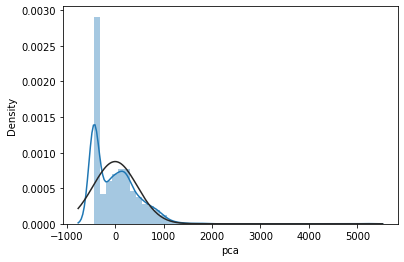

In [77]:
pca=PCA(n_components=1)
pca.fit(df[['BsmtFinSF2', 'BsmtFinSF1']])
print(pca.explained_variance_ratio_)


df['pca']=pca.fit_transform(df[['BsmtFinSF2', 'BsmtFinSF1']])

sns.distplot(df['pca'], fit=norm)
print(plt)

In [78]:
pca=PCA(n_components=1)
pca.fit(df_t[['BsmtFinSF2', 'BsmtFinSF1']])
print(pca.explained_variance_ratio_)


df_t['pca']=pca.fit_transform(df_t[['BsmtFinSF2', 'BsmtFinSF1']])

[0.86955854]


[0.99694576]
<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>


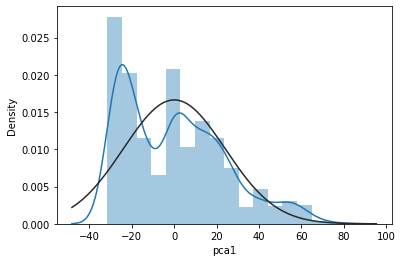

In [79]:
pca1=PCA(n_components=1)
pca1.fit(df[['YrSold', 'GarageYrBlt']])
print(pca1.explained_variance_ratio_)

df['pca1']=pca1.fit_transform(df[['YrSold', 'GarageYrBlt']])

sns.distplot(df['pca1'], fit=norm)
print(plt)

In [80]:
pca1=PCA(n_components=1)
pca1.fit(df_t[['YrSold', 'GarageYrBlt']])
print(pca1.explained_variance_ratio_)

df_t['pca1']=pca1.fit_transform(df_t[['YrSold', 'GarageYrBlt']])

[0.99744404]


[0.830521]
<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>


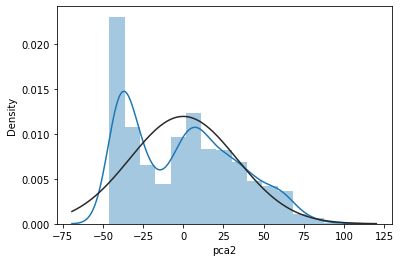

In [81]:
pca2=PCA(n_components=1)
pca2.fit(df[['YearRemodAdd', 'YearBuilt']])
print(pca2.explained_variance_ratio_)

df['pca2']=pca2.fit_transform(df[['YearRemodAdd', 'YearBuilt']])

sns.distplot(df['pca2'], fit=norm)
print(plt)

In [82]:
pca2=PCA(n_components=1)
pca2.fit(df_t[['YearRemodAdd', 'YearBuilt']])
print(pca2.explained_variance_ratio_)

df_t['pca2']=pca2.fit_transform(df_t[['YearRemodAdd', 'YearBuilt']])

[0.84347641]


[0.72564694]
<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>


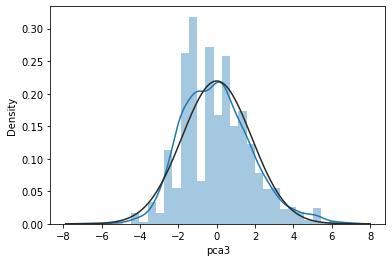

In [83]:
pca3=PCA(n_components=1)
pca3.fit(df[['TotRmsAbvGrd', 'OverallQual']])
print(pca3.explained_variance_ratio_)

df['pca3']=pca3.fit_transform(df[['TotRmsAbvGrd', 'OverallQual']])

sns.distplot(df['pca3'], fit=norm)
print(plt)

In [84]:
pca3=PCA(n_components=1)
pca3.fit(df_t[['TotRmsAbvGrd', 'OverallQual']])
print(pca3.explained_variance_ratio_)

df_t['pca3']=pca3.fit_transform(df_t[['TotRmsAbvGrd', 'OverallQual']])

[0.67749043]


[0.96257079]
<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>


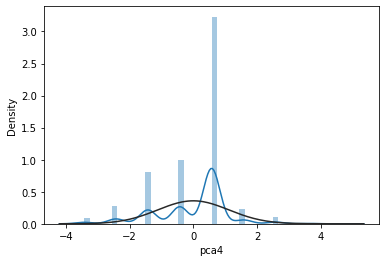

In [85]:
pca4=PCA(n_components=1)
pca4.fit(df[['OverallCond', 'KitchenAbvGr']])
print(pca4.explained_variance_ratio_)

df['pca4']=pca4.fit_transform(df[['OverallCond', 'KitchenAbvGr']])

sns.distplot(df['pca4'], fit=norm)
print(plt)

In [86]:
pca4=PCA(n_components=1)
pca4.fit(df_t[['OverallCond', 'KitchenAbvGr']])
print(pca4.explained_variance_ratio_)

df_t['pca4']=pca4.fit_transform(df_t[['OverallCond', 'KitchenAbvGr']])

[0.96641241]


[0.9999973]
<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>


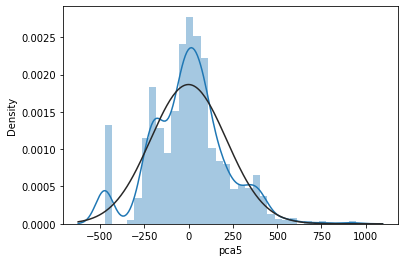

In [87]:
pca5=PCA(n_components=1)
pca5.fit(df[['GarageCars', 'GarageArea']])
print(pca5.explained_variance_ratio_)

df['pca5']=pca5.fit_transform(df[['GarageCars', 'GarageArea']])

sns.distplot(df['pca5'], fit=norm)
print(plt)

In [88]:
pca5=PCA(n_components=1)
pca5.fit(df_t[['GarageCars', 'GarageArea']])
print(pca5.explained_variance_ratio_)

df_t['pca5']=pca5.fit_transform(df_t[['GarageCars', 'GarageArea']])

[0.9999975]


[0.75153978]
<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>


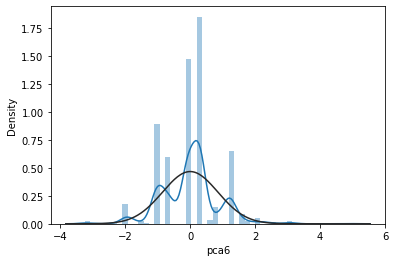

In [89]:
pca6=PCA(n_components=1)
pca6.fit(df[['BedroomAbvGr', 'FullBath']])
print(pca6.explained_variance_ratio_)

df['pca6']=pca6.fit_transform(df[['BedroomAbvGr', 'FullBath']])

sns.distplot(df['pca6'], fit=norm)
print(plt)

In [90]:
pca6=PCA(n_components=1)
pca6.fit(df_t[['BedroomAbvGr', 'FullBath']])
print(pca6.explained_variance_ratio_)

df_t['pca6']=pca6.fit_transform(df_t[['BedroomAbvGr', 'FullBath']])

[0.74990639]


[0.99166604]
<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>


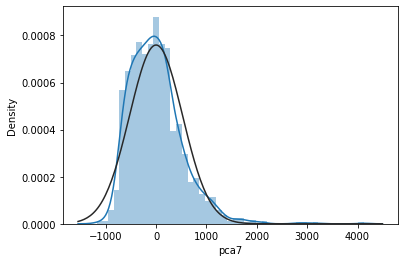

In [91]:
pca7=PCA(n_components=1)
pca7.fit(df[['LowQualFinSF', 'GrLivArea']])
print(pca7.explained_variance_ratio_)

df['pca7']=pca7.fit_transform(df[['LowQualFinSF', 'GrLivArea']])

sns.distplot(df['pca7'], fit=norm)
print(plt)

In [92]:
pca7=PCA(n_components=1)
pca7.fit(df_t[['LowQualFinSF', 'GrLivArea']])
print(pca7.explained_variance_ratio_)

df_t['pca7']=pca7.fit_transform(df_t[['LowQualFinSF', 'GrLivArea']])

[0.9918606]


[0.61734791]
<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>


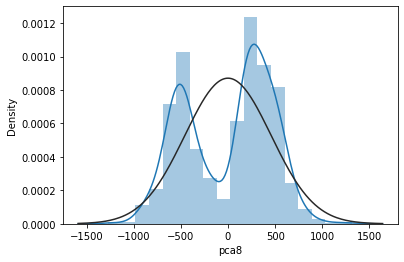

In [93]:
pca8=PCA(n_components=1)
pca8.fit(df[['2ndFlrSF', '1stFlrSF']])
print(pca8.explained_variance_ratio_)

df['pca8']=pca8.fit_transform(df[['2ndFlrSF', '1stFlrSF']])

sns.distplot(df['pca8'], fit=norm)
print(plt)

In [94]:
pca8=PCA(n_components=1)
pca8.fit(df_t[['2ndFlrSF', '1stFlrSF']])
print(pca8.explained_variance_ratio_)

df_t['pca8']=pca8.fit_transform(df_t[['2ndFlrSF', '1stFlrSF']])

[0.65138593]


[0.70770548]
<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>


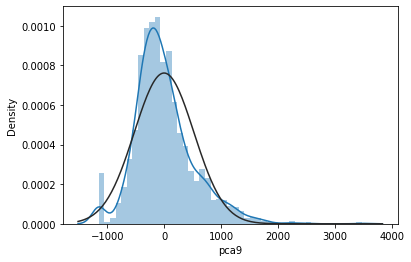

In [95]:
pca9=PCA(n_components=1)
pca9.fit(df[['TotalBsmtSF', 'BsmtUnfSF']])
print(pca9.explained_variance_ratio_)

df['pca9']=pca9.fit_transform(df[['TotalBsmtSF', 'BsmtUnfSF']])

sns.distplot(df['pca9'], fit=norm)
print(plt)

In [96]:
pca9=PCA(n_components=1)
pca9.fit(df_t[['TotalBsmtSF', 'BsmtUnfSF']])
print(pca9.explained_variance_ratio_)

df_t['pca9']=pca9.fit_transform(df_t[['TotalBsmtSF', 'BsmtUnfSF']])

[0.70459511]


In [97]:
numeric_feature

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [98]:
numeric_feature_t

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [100]:
# 수정
numeric_feature = ['MSSubClass', 'LotFrontage', 'LotArea', 'pca3',
       'pca2', 'MasVnrArea', 'BsmtFinSF2', 'pca9', '1stFlrSF', '2ndFlrSF',
       'pca7', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'pca4',
       'Fireplaces', 'pca1', 'pca5', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'SalePrice']

In [101]:
numeric_feature_t = ['MSSubClass', 'LotFrontage', 'LotArea', 'pca3',
       'pca2', 'MasVnrArea', 'BsmtFinSF2', 'pca9', '1stFlrSF', '2ndFlrSF',
       'pca7', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'pca4',
       'Fireplaces', 'pca1', 'pca5', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold']

Index(['SalePrice', 'pca3', 'pca7', 'pca5', '1stFlrSF', 'FullBath', 'pca9',
       'MasVnrArea', 'Fireplaces', 'LotFrontage', 'WoodDeckSF', '2ndFlrSF',
       'OpenPorchSF', 'HalfBath', 'LotArea'],
      dtype='object')


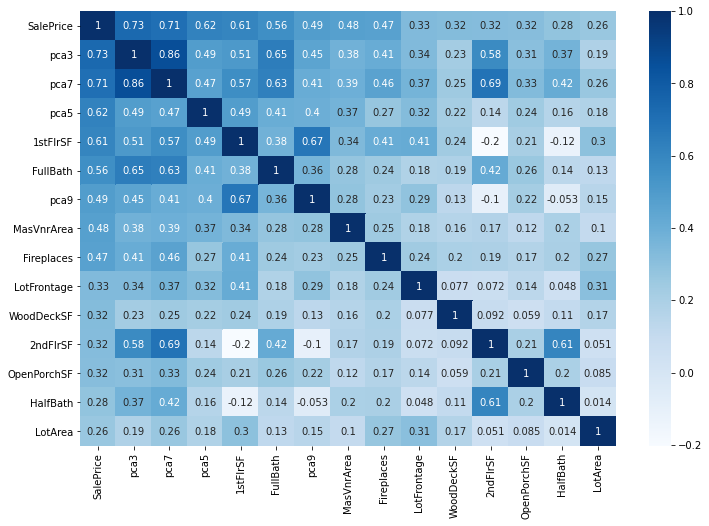

In [48]:
saleprice_corr_feature  = df[numeric_feature].corr().nlargest(15, 'SalePrice').index
print(saleprice_corr_feature)
plt.figure(figsize=(12,8))
sns.heatmap(df[saleprice_corr_feature].corr(), annot=True, cmap='Blues')
plt.show()

In [49]:
# saleprice_corr_feature  = df[numeric_feature].corr().nsmallest(15, 'SalePrice').index
# print(saleprice_corr_feature)
# plt.figure(figsize=(12,8))
# sns.heatmap(df[saleprice_corr_feature].corr(), annot=True, cmap='Blues')
# plt.show()

** 상관분석 결과 다중공선 우려
'SalePrice' :  'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 
               'YearBuilt', 'TotalBsmtSF', 'FullBath', 'YearRemodAdd', '1stFlrSF', 'GarageYrBlt', 'TotRmsAbvGrd',
               'Fireplaces', 'OpenPorchSF', 'MasVnrArea'
'SalePrice' 'OverallQual' : 'GrLivArea', 
'GarageCars'  : 'GarageArea' 
'YearBuilt' :  'GarageYrBlt',  'YearRemodAdd'
'TotalBsmtSF'  '1stFlrSF'
'FullBath':  'GrLivArea'
'YearRemodAdd' : 'YearBuilt',  'YearRemodAdd'

target(SalePrice)에 영향을 주는 상위 n개 피쳐에 대해서만 데이터 분포도(산점도) 확인

In [50]:
# #saleprice_corr_feature = ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea','YearBuilt', 'TotalBsmtSF', 'FullBath', 'YearRemodAdd', '1stFlrSF', 'GarageYrBlt', 'TotRmsAbvGrd']
# plt.figure(figsize=(30,5))
# # i: index
# for i, col in enumerate(saleprice_corr_feature):
    
#     # 3 plots here hence 1, 3
#     plt.subplot(1, len(saleprice_corr_feature), i+1)
#     x = df[col]
#     y = df['SalePrice']
#     plt.plot(x, y, 'o')
    
#     # Create regression Line
#     plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
#     plt.title(col)
#     plt.xlabel(col)
#     plt.ylabel('prices')

### 5. 숫자 모양의 object형 피쳐 인코딩

원-핫 인코딩은 간단히 말해 한 개의 요소는 True, 나머지 요소는 False로 만들어 주는 기법이다.

※ 원-핫 인코딩이 필요한 이유?
scikit-learn에서 제공하는 머신러닝 알고리즘은 문자열 값을 입력 값으로 허락하지 않기 때문에 모든 문자열 값들을 숫자형으로 인코딩하는 전처리 작업(Preprocessing) 후에 머신러닝 모델에 학습을 시켜야 한다.

scikit-learn 에서 제공하는 머신러닝 알고리즘에 데이터를 넣을 수 있는 기본 조건은 다음과 같다.
– 모든 데이터는 숫자(정수형, 실수형 등)로 구성되어 있어야 한다.
– 데이터에 빈 값이 없어야 한다.

In [51]:
# select distinct deptno from emp;
#수치형 : 0/1/2 코드성 수치
oh_numeric_feature = []
for col in numeric_feature:
    if df[col].nunique() <= 15:
        print(col, df[col].unique())
        oh_numeric_feature.append(col)
print("인코딩 적용 전 :",df.shape)

oh_numeric_feature.remove('MSSubClass')
oh_numeric_feature.remove('PoolArea')
print("인코딩 대상 피쳐 :", oh_numeric_feature)

df_oh = pd.get_dummies(data=df, columns=oh_numeric_feature)
print("인코딩 적용 후 :",df_oh.shape)
print(df_oh.head())

MSSubClass [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]
BsmtFullBath [1 0 2 3]
BsmtHalfBath [0 1 2]
FullBath [2 1 3 0]
HalfBath [1 0 2]
BedroomAbvGr [3 4 1 2 0 5 6 8]
Fireplaces [0 1 2 3]
PoolArea [  0 512 648 576 555 480 519 738]
MoSold [ 2  5  9 12 10  8 11  4  1  7  3  6]
인코딩 적용 전 : (1460, 85)
인코딩 대상 피쳐 : ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'Fireplaces', 'MoSold']
인코딩 적용 후 : (1460, 116)
   MSSubClass MSZoning  LotFrontage  ...  MoSold_10 MoSold_11 MoSold_12
0          60       RL         65.0  ...          0         0         0
1          20       RL         80.0  ...          0         0         0
2          60       RL         68.0  ...          0         0         0
3          70       RL         60.0  ...          0         0         0
4          60       RL         84.0  ...          0         0         1

[5 rows x 116 columns]


In [52]:
df_oh

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,...,pca8,pca9,BsmtFullBath_0,BsmtFullBath_1,BsmtFullBath_2,BsmtFullBath_3,BsmtHalfBath_0,BsmtHalfBath_1,BsmtHalfBath_2,FullBath_0,FullBath_1,FullBath_2,FullBath_3,HalfBath_0,HalfBath_1,HalfBath_2,BedroomAbvGr_0,BedroomAbvGr_1,BedroomAbvGr_2,BedroomAbvGr_3,BedroomAbvGr_4,BedroomAbvGr_5,BedroomAbvGr_6,BedroomAbvGr_8,Fireplaces_0,Fireplaces_1,Fireplaces_2,Fireplaces_3,MoSold_1,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,...,-592.266123,-438.768292,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,...,350.945462,-58.607282,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,...,-571.198822,-191.359744,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,...,-455.269268,-230.720240,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,...,-623.176568,6.296958,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,...,-405.244451,201.918918,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1456,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,...,750.260437,355.187526,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
1457,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,...,-688.172517,287.209078,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
1458,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,Y,...,260.348722,-390.132067,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [53]:
# select distinct deptno from emp;
#수치형 : 0/1/2 코드성 수치
oh_numeric_feature_t = []
for col in numeric_feature_t:
    if df_t[col].nunique() <= 15:
        print(col, df_t[col].unique())
        oh_numeric_feature_t.append(col)
print("인코딩 적용 전 :",df_t.shape)

# oh_numeric_feature_t.remove('MSSubClass')
oh_numeric_feature_t.remove('PoolArea')
print("인코딩 대상 피쳐 :", oh_numeric_feature_t)

df_t_oh = pd.get_dummies(data=df_t, columns=oh_numeric_feature_t)
print("인코딩 적용 후 :",df_t_oh.shape)
print(df_t_oh.head())

BsmtFullBath [0.         1.         2.         3.         0.43445436]
BsmtHalfBath [0.         1.         0.06520247 2.        ]
FullBath [1 2 3 4 0]
HalfBath [0 1 2]
BedroomAbvGr [2 3 4 1 6 5 0]
Fireplaces [0 1 2 3 4]
3SsnPorch [  0 224 255 225 360 150 153 174 120 219 176  86 323]
PoolArea [  0 144 368 444 228 561 800]
MoSold [ 6  3  1  4  5  2  7 10  8 11  9 12]
인코딩 적용 전 : (1459, 84)
인코딩 대상 피쳐 : ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'Fireplaces', '3SsnPorch', 'MoSold']
인코딩 적용 후 : (1459, 130)
   MSSubClass MSZoning  LotFrontage  ...  MoSold_10 MoSold_11 MoSold_12
0          20       RH         80.0  ...          0         0         0
1          20       RL         81.0  ...          0         0         0
2          60       RL         74.0  ...          0         0         0
3          60       RL         78.0  ...          0         0         0
4         120       RL         43.0  ...          0         0         0

[5 rows x 130 columns]


In [54]:
print(oh_numeric_feature)
print(oh_numeric_feature_t)

['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'Fireplaces', 'MoSold']
['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'Fireplaces', '3SsnPorch', 'MoSold']


- nunique가 15개보다 작다는것은 숫자로 된 범주형일 확률이 높다는 뜻이다. => 범주형 찾아서 원핫인코딩
- 다만, 그 안에서도 범주형으로 보기 애매한게 있을 수 있으므로 주의해야 한다.

### 6. 수치형 정규화
타켓 분포도 확인/정규화

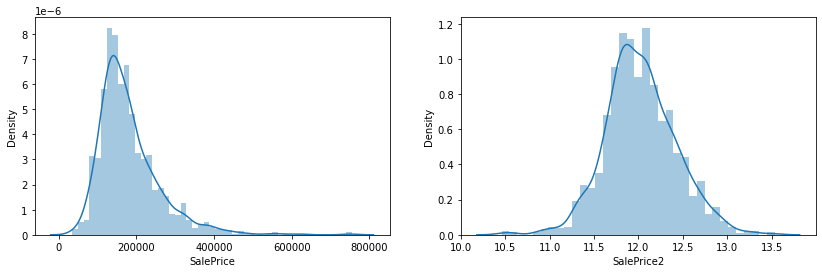

In [55]:
# MinMaxScaler: 0 ~ 1
# StandardScaler: 평균0 분산1(정규분포)
# np.log()
#  : max을 0으로두고 다른값을 뺀 그 차이값을 이용
# np.log1p()
# : log를 취한값이 너무 작으면 언더플로우가 나기 때문에 1을 더해서 사용

df_oh['SalePrice2'] = np.log1p(df_oh['SalePrice'])

f, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
sns.distplot(df_oh['SalePrice'],  ax=axes[0])
sns.distplot(df_oh['SalePrice2'], ax=axes[1])
plt.show()

수치형 피쳐 : skew() kurt() 왜도/첨도확인

왜도(비대칭도)란, 확률변수의 확률분포가 비대칭성을 의미한다
a=0이면 정규분포, a<0이면 오른쪽으로 치우침, a>0이면 왼쪽으로 치우침을 의미한다.

첨도란(Kurtosis), 확률분포의 뾰족한 정도를 의미한다
a=3이면 정규분포, a<3이면 정규분포보다 완만함, a>3이면 정규분포 보다 뾰족함을 의미한다.

In [56]:
#============== skew() kurt() 왜도/첨도 확인
sk_df = pd.DataFrame()

# sns.distplot(df[col])
#왜도 : 대칭=0(정규분포) <0 :오른쪽편중  >0:왼쪽편중
sk_df["skew"] = df_oh[numeric_feature].skew()
#첨도 : 뾰족함(중앙 편중)
sk_df["kurt"] = df_oh[numeric_feature].kurt()
print(sk_df.head(40).sort_values("skew", ascending=False))

#============== skew() kurt() 왜도/첨도 확인 ----------------------------(test용 )
sk_df_t = pd.DataFrame()

# sns.distplot(df[col])
#왜도 : 대칭=0(정규분포) <0 :오른쪽편중  >0:왼쪽편중
sk_df_t["skew"] = df_t_oh[numeric_feature_t].skew()
#첨도 : 뾰족함(중앙 편중)
sk_df_t["kurt"] = df_t_oh[numeric_feature_t].kurt()
print(sk_df_t.head(40).sort_values("skew", ascending=False))

KeyError: ignored

In [ ]:
skew_feature = sk_df.head(40).sort_values("skew", ascending=False)[:15].index
skew_feature = skew_feature # - oh_numeric_feature

df[skew_feature].hist(bins=10, figsize=(20,10), grid=False)
plt.show()

In [ ]:
for col in skew_feature:
    df[col] = np.log1p(df[col]) #그냥 log보다 log1p는 엄청 작은 값도 잡아준다.
df[skew_feature].hist(bins=10, figsize=(20,10), grid=False)
plt.show()

In [ ]:
# BsmtFinSF1 : BsmtUnitSF : BstmtFullBath
# YearBuiltin : EnclosedPoach

# taget 피쳐와 상관관계가 가장 높은 피쳐들을 확인 --> 시각화
# taget 피쳐를 제외한 모든 수치형 피쳐들간에 상관관계  --> 다중공선없엔다(drop대상)

### 7. Object형 시각화

In [ ]:
#수정

df2 = df_oh
drop_list = ['pca', 'BsmtFinSF1', 'YrSold', 'GarageYrBlt', 'YearRemodAdd', 'YearBuilt', 'TotRmsAbvGrd', 'OverallQual', 'OverallCond', 'KitchenAbvGr', 'GarageCars', 'GarageArea', 'LowQualFinSF', 'GrLivArea', 'TotalBsmtSF', 'BsmtUnfSF']
df2 = df2.drop(drop_list, axis=1)


#---------------------------(test)

df2_t = df_t_oh
drop_list_t = ['pca', 'BsmtFinSF1', 'YrSold', 'GarageYrBlt', 'YearRemodAdd', 'YearBuilt', 'TotRmsAbvGrd', 'OverallQual', 'OverallCond', 'KitchenAbvGr', 'GarageCars', 'GarageArea', 'LowQualFinSF', 'GrLivArea', 'TotalBsmtSF', 'BsmtUnfSF']
df2_t = df2_t.drop(drop_list_t, axis=1)

In [ ]:
#============== matplot.plt(box)
df2.plot(kind='box', subplots=True, figsize=(20, 15), layout=(4,8), sharex=False, sharey=False)
plt.show()

In [ ]:
outlier_list = ['BsmtHalfBath', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch', 'PoolArea', 'MiscVal','BsmtFinSF2']
#BsmtFinSF2  아웃라이어 값이 전체이므로 삭제처리

df2 = df2.drop(outlier_list, axis=1)

In [ ]:
# (test용)
outlier_list_t = ['BsmtHalfBath', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch', 'PoolArea', 'MiscVal','BsmtFinSF2']
#BsmtFinSF2  아웃라이어 값이 전체이므로 삭제처리

df2_t = df2_t.drop(outlier_list_t, axis=1)

In [ ]:
#============== matplot.plt(box)
df2.plot(kind='box', subplots=True, figsize=(20, 15), layout=(4,8), sharex=False, sharey=False)
plt.show()

In [ ]:
#============== matplot.plt(box) (test용 확인 그래프)
df2_t.plot(kind='box', subplots=True, figsize=(20, 15), layout=(4,8), sharex=False, sharey=False)
plt.show()

In [ ]:
#============== sns.boxplot()
object_feature = df2.dtypes[df.dtypes == 'object'].index
print(object_feature)
fig, axs = plt.subplots(figsize=(20,30), ncols=5, nrows=8)
for i, feature in enumerate(object_feature):
    row = int(i / 5) 
    col = i % 5
    # seaborn의 regplot 이용하여 박스플롯
    sns.boxplot(x=feature, y='SalePrice', data=df2, ax=axs[row][col])

In [ ]:
#==========test용 ================
object_feature_t = df2_t.dtypes[df_t.dtypes == 'object'].index
print(object_feature_t)


In [ ]:
df2 = df2.drop(['Street', 'Utilities', 'LotConfig', 'LandSlope', 'BldgType', 'RoofStyle', 'PavedDrive', 'LotShape', 'LandContour'], axis=1)

In [ ]:
df2_t = df2_t.drop(['Street', 'Utilities', 'LotConfig', 'LandSlope', 'BldgType', 'RoofStyle', 'PavedDrive', 'LotShape', 'LandContour'], axis=1)

#'MSSubClass'

In [ ]:
#============== sns.boxplot() --지워졌는지 아닌지 확인용~
object_feature = df2.dtypes[df.dtypes == 'object'].index
print(object_feature)
fig, axs = plt.subplots(figsize=(20,30), ncols=5, nrows=6)
for i, feature in enumerate(object_feature):
    row = int(i / 5) 
    col = i % 5
    # seaborn의 regplot 이용하여 박스플롯
    sns.boxplot(x=feature, y='SalePrice', data=df2, ax=axs[row][col])

** target(SalePrice)에 영향을 미치는(각 피쳐별로 값의 중앙값의 편차가 크다) 피쳐 선정



● 'SalePrice', 상관성이 높은 피쳐(회귀계수)
    카테고리(object)형 : 
     'MSZoning', 'Neighborhood', 'Condition1', 'Condition2', 'SaleType'

    수치형 : 
     'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
     'YearBuilt', 'TotalBsmtSF', 'FullBath', 'YearRemodAdd', '1stFlrSF',
     'GarageYrBlt', 'TotRmsAbvGrd', 'Fireplaces', 'OpenPorchSF',
     'MasVnrArea'

    *다중공선 해결 

    'GarageCars', 'GarageArea',

    'GrLivArea','TotRmsAbvGrd'

    'GarageYrBlt','YearBuilt'

    '1stFlrSF','TotalBsmtSF'


</pre>

### 8. Outlier 탐지
IQR (Inter Quartile Range). IQR 이란 상위 75% 지점의 값과 하위 25 지점의 값 차이를 의미한다.

최솟값 : 제 1사분위에서 1.5 IQR1을 뺀 위치이다.
제 1사분위(Q1) : 25%의 위치를 의미한다.
제 2사분위(Q2) : 50%의 위치로 중앙값(median)을 의미한다.
제 3사분위(Q3) : 75%의 위치를 의미한다.
최댓값 : 제 3사분위에서 1.5 IQR을 더한 위치이다.
최솟값과 최댓값을 넘어가는 위치에 있는 값을 이상치(Outlier)라고 부른다.

In [ ]:
from collections import Counter
def detect_outliers(df2, n, features):
    outlier_idx_list = []
    for col in features:
        Q1 = np.percentile(df2[col], 25)
        Q3 = np.percentile(df2[col], 75)
        IQR = Q3 - Q1
        IQR15 = 1.5 * IQR
        outlier_list_col = df2[(df2[col] < Q1 - IQR15) | (df2[col] > Q3 + IQR15)].index
        outlier_idx_list.extend(outlier_list_col)
    outlier_idx_list = Counter(outlier_idx_list)
    multiple_outliers = list(k for k, v in outlier_idx_list.items() if v > n)
    return multiple_outliers

In [ ]:
#아웃라이어 감지 test

from collections import Counter
def detect_outliers(df2_t, n, features):
    outlier_idx_list = []
    for col in features:
        Q1 = np.percentile(df2_t[col], 25)
        Q3 = np.percentile(df2_t[col], 75)
        IQR = Q3 - Q1
        IQR15 = 1.5 * IQR
        outlier_list_col = df2_t[(df2_t[col] < Q1 - IQR15) | (df2_t[col] > Q3 + IQR15)].index
        outlier_idx_list.extend(outlier_list_col)
    outlier_idx_list = Counter(outlier_idx_list)
    multiple_outliers = list(k for k, v in outlier_idx_list.items() if v > n)
    return multiple_outliers

In [ ]:
# numeric_feature --> 전처리 전 숫자형 컬럼들 / numeric_feature2 --> 전처리 후 숫자형 컬럼들
numeric_feature2 = df2.dtypes[df2.dtypes != 'object'].index

In [ ]:
# numeric_feature --> 전처리 전 숫자형 컬럼들 / numeric_feature2 --> 전처리 후 숫자형 컬럼들
numeric_feature2_t = df2_t.dtypes[df2_t.dtypes != 'object'].index

In [ ]:
outlier_drop_feature = detect_outliers(df2, 2, numeric_feature2)
print(outlier_drop_feature)

print("Outlier 처리전:", df2.shape)
df2 = df2.drop(outlier_drop_feature, axis = 0).reset_index(drop=True)
print("Outlier 처리후:", df2.shape)

In [ ]:
# outlier_drop_feature_t = detect_outliers(df2_t, 2, numeric_feature2_t)
# print(outlier_drop_feature)

# print("Outlier 처리전:", df2_t.shape)
# df2_t = df2_t.drop(outlier_drop_feature, axis = 0).reset_index(drop=True)
# print("Outlier 처리후:", df2_t.shape)

In [ ]:
# df2['pca'].isnull().sum()

### 9. Object형 피쳐 인코딩

In [ ]:
df2

In [ ]:
df3 = df2.append(df2_t)
df3

In [ ]:
print("인코딩 적용 전 :",df3.shape)
df_oh3 = pd.get_dummies(data=df2, columns=object_feature)
print("인코딩 적용 후 :",df_oh3.shape)

In [ ]:
# # Object Type : 
# # LabelEncoding (Pool Extend ... Excellent : 0 1 ... 33)
# # OneHotEncoding (1000 0100  0010 0001) :피쳐가 엄청~ 많아진다(시각화X, 분석용)


# # pd.get_dummy() --> dummy는 행을 열에 늘리는 거니까 train하고 test하고 행이 다른 상황이라 합쳐서 더미를 하고 나눠야 한다.

# print("인코딩 적용 전 :",df2.shape)
# df2_oh = pd.get_dummies(data=df2, columns=object_feature)
# print("인코딩 적용 후 :",df2_oh.shape)

In [ ]:
df2[object_feature].info()

In [ ]:
# test용 인코딩 

print("인코딩 적용 전 :",df2_t.shape)
df2_t_oh = pd.get_dummies(data=df2_t, columns=object_feature)
print("인코딩 적용 후 :",df2_t_oh.shape)

In [ ]:
df_oh.head()

### 10. 학습모델 선정 / 평가

In [ ]:
y_log = df_oh['SalePrice2']
y = df_oh['SalePrice']
X_oh = df_oh.drop(['SalePrice','SalePrice2'], axis=1)

# ---- 데이터 셋 ------------------------
X_train7, X_test3,  y_train7, y_test3  \
#    = train_test_split(X_oh, y_log, test_size=0.3, random_state=11)

In [ ]:
y_log

In [ ]:
y_train7.head()

In [ ]:
# pp = pd.DataFrame(X_train7.isnull().sum())
# pp.T

In [ ]:
# ---- 개별 분류 모델 -------------------
lr = LinearRegression()
ridge = Ridge()
lasso = Lasso()

for model_name, model in [("LR", lr), ("Ridge", ridge), ("Lasso", lasso)]:
    model.fit(X_train7, y_train7)
    pred = model.predict(X_test3)
    print(model_name , mean_squared_error(y_test3, pred))

In [ ]:
#----- cross_val_score-------

for model_name, model in [("LR", lr), ("Ridge", ridge), ("Lasso", lasso)]:
    neg_mse_scores = cross_val_score(model, X_oh, y_log, scoring="neg_mean_squared_error", cv = 5)
    rmse_scores  = np.sqrt(-1 * neg_mse_scores) #차이를 극대화해서 보려고 neg를 쓰므로 -1해서 양수로 바꿔야함
    avg_rmse = np.mean(rmse_scores)
    print(model_name, ' 5 folds 의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 3))
    print(model_name, ' 5 folds 의 개별 RMSE scores : ', np.round(rmse_scores,3))
    print(model_name, ' 5 folds 의 평균 RMSE : {0:.3f} '.format(avg_rmse))
    print()

In [ ]:
# 각 모델에 따른 회귀 계수 값을 시각화하기 위해 5개의 열로 된 맷플롯립 축 생성
models = [lr, ridge, lasso]
    
fig , axs = plt.subplots(figsize=(12,12) , nrows=1 , ncols=3)
# 각 alpha에 따른 회귀 계수 값을 데이터로 저장하기 위한 DataFrame 생성  
coef_df = pd.DataFrame()
plt.xticks(fontsize=15)

# alphas 리스트 값을 차례로 입력해 회귀 계수 값 시각화 및 데이터 저장. pos는 axis의 위치 지정
for pos , model in enumerate(models) :
    model.fit(X_train7, y_train7)
    # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼으로 추가.  
    coef = pd.Series(data=model.coef_ , index=X_train7.columns )
    coef_head = coef.sort_values(ascending=False).head(15)
    coef_tail = coef.sort_values(ascending=False).tail(15)
    coef = pd.concat([coef_head, coef_tail])
    coef_df[model] = coef
    # 막대 그래프로 각 alpha 값에서의 회귀 계수를 시각화. 회귀 계수값이 높은 순으로 표현--------------------추가코드
    coef = coef.sort_values(ascending=False)
    axs[pos].set_title(model)
    
#     axs[pos].set_xlim(-0.2,0.2)
    sns.barplot(x=coef.values , y=coef.index, ax=axs[pos])
# for 문 바깥에서 맷플롯립의 show 호출 및 alpha에 따른 피처별 회귀 계수를 DataFrame으로 표시

plt.show()

### 13.모델 검증 및 튜닝

In [ ]:
myprm = {'alpha':[0.05,0.1,0.5,1.0,3.0,10.0, 20.0]}
best_model = GridSearchCV(ridge, param_grid=myprm,
             scoring="neg_mean_squared_error",verbose=0,
             refit=True, cv=5)
best_model.fit(X_train7, y_train7)
print("베스트 점수:",best_model.best_score_)
print("베스트 파라미터:",best_model.best_params_)

best_pred = best_model.predict(df_t_oh)
# mse = mean_squared_error(y_test3, best_pred)
# print(mse, np.sqrt(mse))

- best_param 중심으로 튜닝 값 재조정
- alpha값 변화를 시각화해서 확인

In [ ]:
print("submit시 제출할 예측 집값(로그변환값) :\n", best_pred[:5])
print("원본값으로 변환:\n", np.round(np.expm1(best_pred),0)[:5])

In [ ]:
myprm = [1.0, 1,5,8.0,9.0,10.0,11.0,12.0,15,20,50]
score_list = []
for ap in myprm:
    ridge = Ridge(alpha=ap)
    neg_mse_scores5 = cross_val_score(ridge, X_oh, y_log, 
                scoring="neg_mean_squared_error", cv = 5)
    rmse_scores5  = np.sqrt(-1 * neg_mse_scores5)
    avg_rmse = np.mean(rmse_scores5)
    print(avg_rmse)  
    score_list.append(avg_rmse)

In [ ]:
plt.plot(myprm, score_list)
plt.show()

In [ ]:
sub_df = pd.read_csv("sample_submission.csv")
mydic = {"Id": sub_df["Id"],
         "SalePrice" : np.round(np.expm1(best_pred),0)
         }
sub_df = pd.DataFrame(mydic, index=None)
print(sub_df.head())
sub_df.to_csv("sample_submission22.csv", index=None)